In [7]:
%reload_ext autoreload
%autoreload 2

import os
import pickle
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import adfuller
from data_preprocessing import download_stock_data, calculate_daily_returns, calculate_volume_weighted_returns, save_to_pkl, load_from_pkl
from pca_factors import perform_pca, plot_explained_variance , analyze_pca_components_over_time
from eigenportfolio_utils import construct_eigenportfolios, plot_eigenportfolio_weights, compute_eigenportfolio_returns, plot_eigenportfolio_returns
from ou_params import calculate_ou_parameters, create_adf_heatmap , analyze_and_plot_taus, plot_s_scores
from backtest import backtesting, calculate_sharpe_ratios, plot_cumulative_return

In [9]:
variables = ['adjusted_close_clean', 'volume_clean_data', 'daily_returns', 'volume_weighted_returns', 
             'nifty_returns', 'tickers']+\
            [f'pca_{x}' for x in ['dr','vw','dr1','dr15','dr55','dr75','vw1','vw15','vw55','vw75' ]] + \
            [f'eigenportfolios_{x}' for x in ['dr1','dr15','dr55','dr75','vw1','vw15','vw55','vw75']] + \
            [f'eigenportfolio_returns_{x}' for x in ['dr1','dr15','dr55','dr75','vw1','vw15','vw55','vw75']] + \
            [f'ou_parameters_{x}' for x in ['dr1','dr15','dr55','dr75','vw1','vw15','vw55','vw75']] + \
            [f'backtest_{x}_{y}x' if y else f'backtest_{x}' 
             for x in ['dr1','dr15','dr55','dr75','vw1','vw15','vw55','vw75'] 
             for y in [None,2,3,4,5]]

globals().update({var: load_from_pkl(f'{var}.pkl') for var in variables})

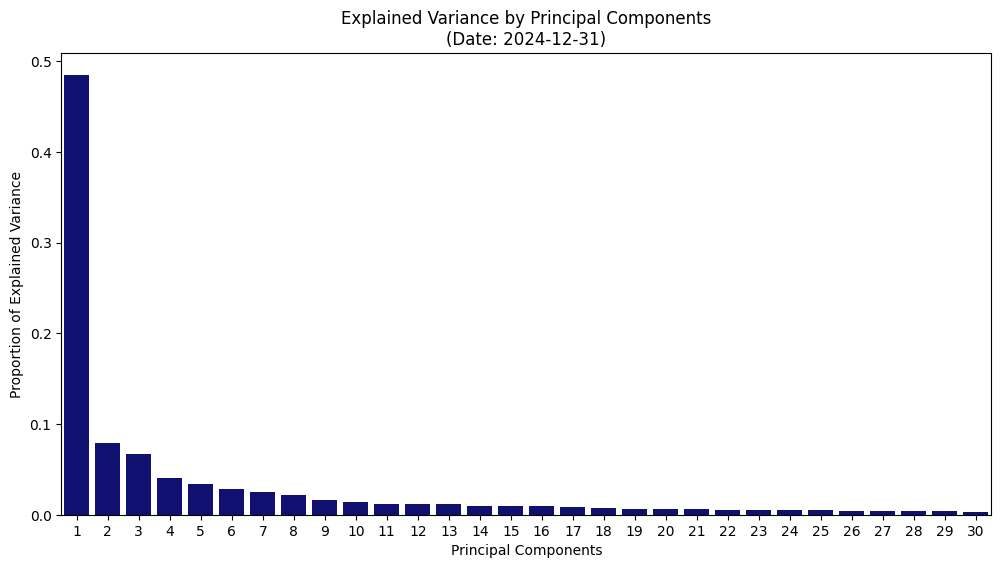

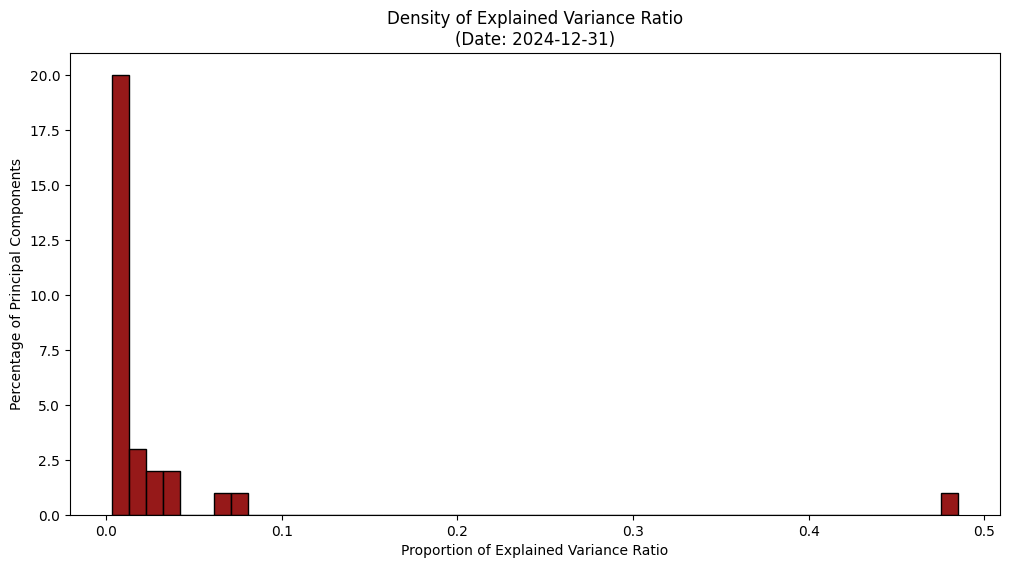


PCA Analysis for date: 2024-12-31
First PC explained variance: 48.49%
Top 3 PCs cumulative variance: 63.08%
Top 5 PCs cumulative variance: 70.50%
Number of components shown: 30

Components needed for variance thresholds:
55% variance: 2 components
65% variance: 4 components
75% variance: 7 components
85% variance: 14 components
95% variance: 31 components


In [17]:
plot_explained_variance(pca_dr, n_components=30)

/Users/niteshrai/Desktop/StatArb/pca_factors.py:296: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


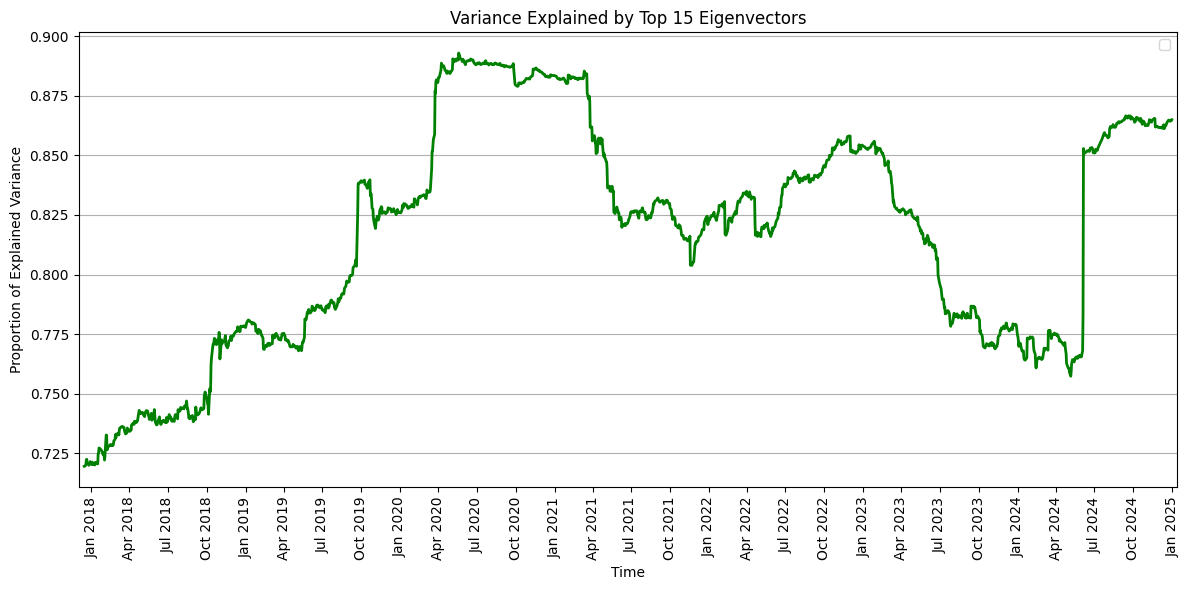


Proportion of Variance explained by top 15 eigenvectors:
Mean: 81.66%
Min: 71.96%
Max: 89.29%
Std: 4.68%


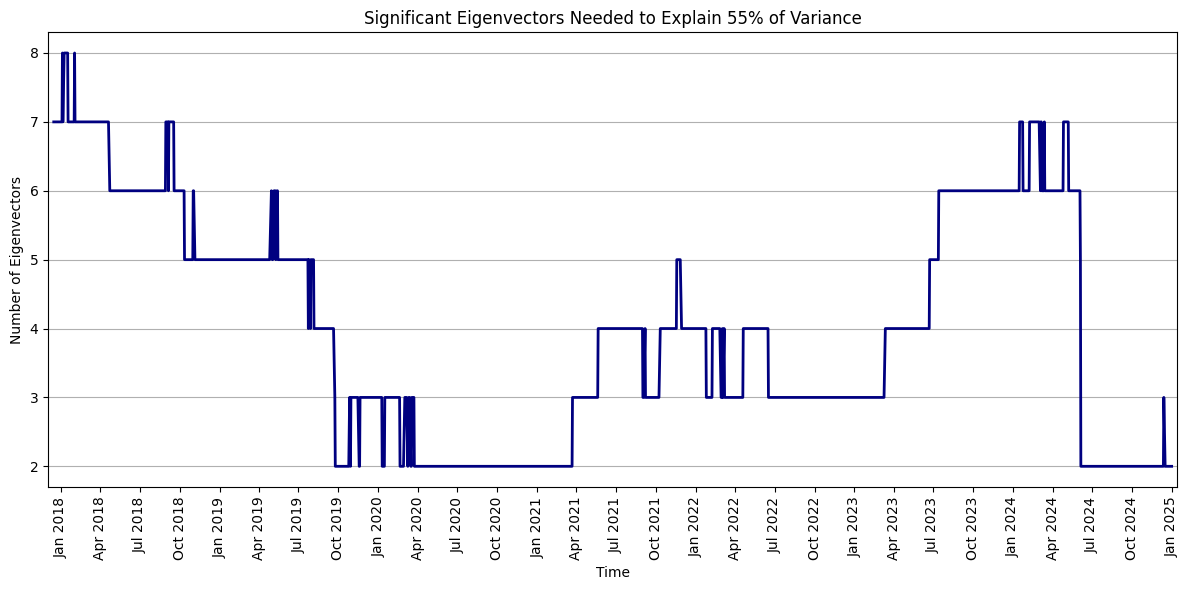


Significant eigenvectors needed for 55% variance:
Mean: 3.98
Min: 2
Max: 8
Std: 1.65


In [18]:
analyze_pca_components_over_time(pca_dr, start_date= np.datetime64("2017-12-15"), end_date=np.datetime64("2024-12-31"), n_components=15)
analyze_pca_components_over_time(pca_dr, start_date= np.datetime64("2017-12-15"), end_date=np.datetime64("2024-12-31"), variance_threshold=0.55)

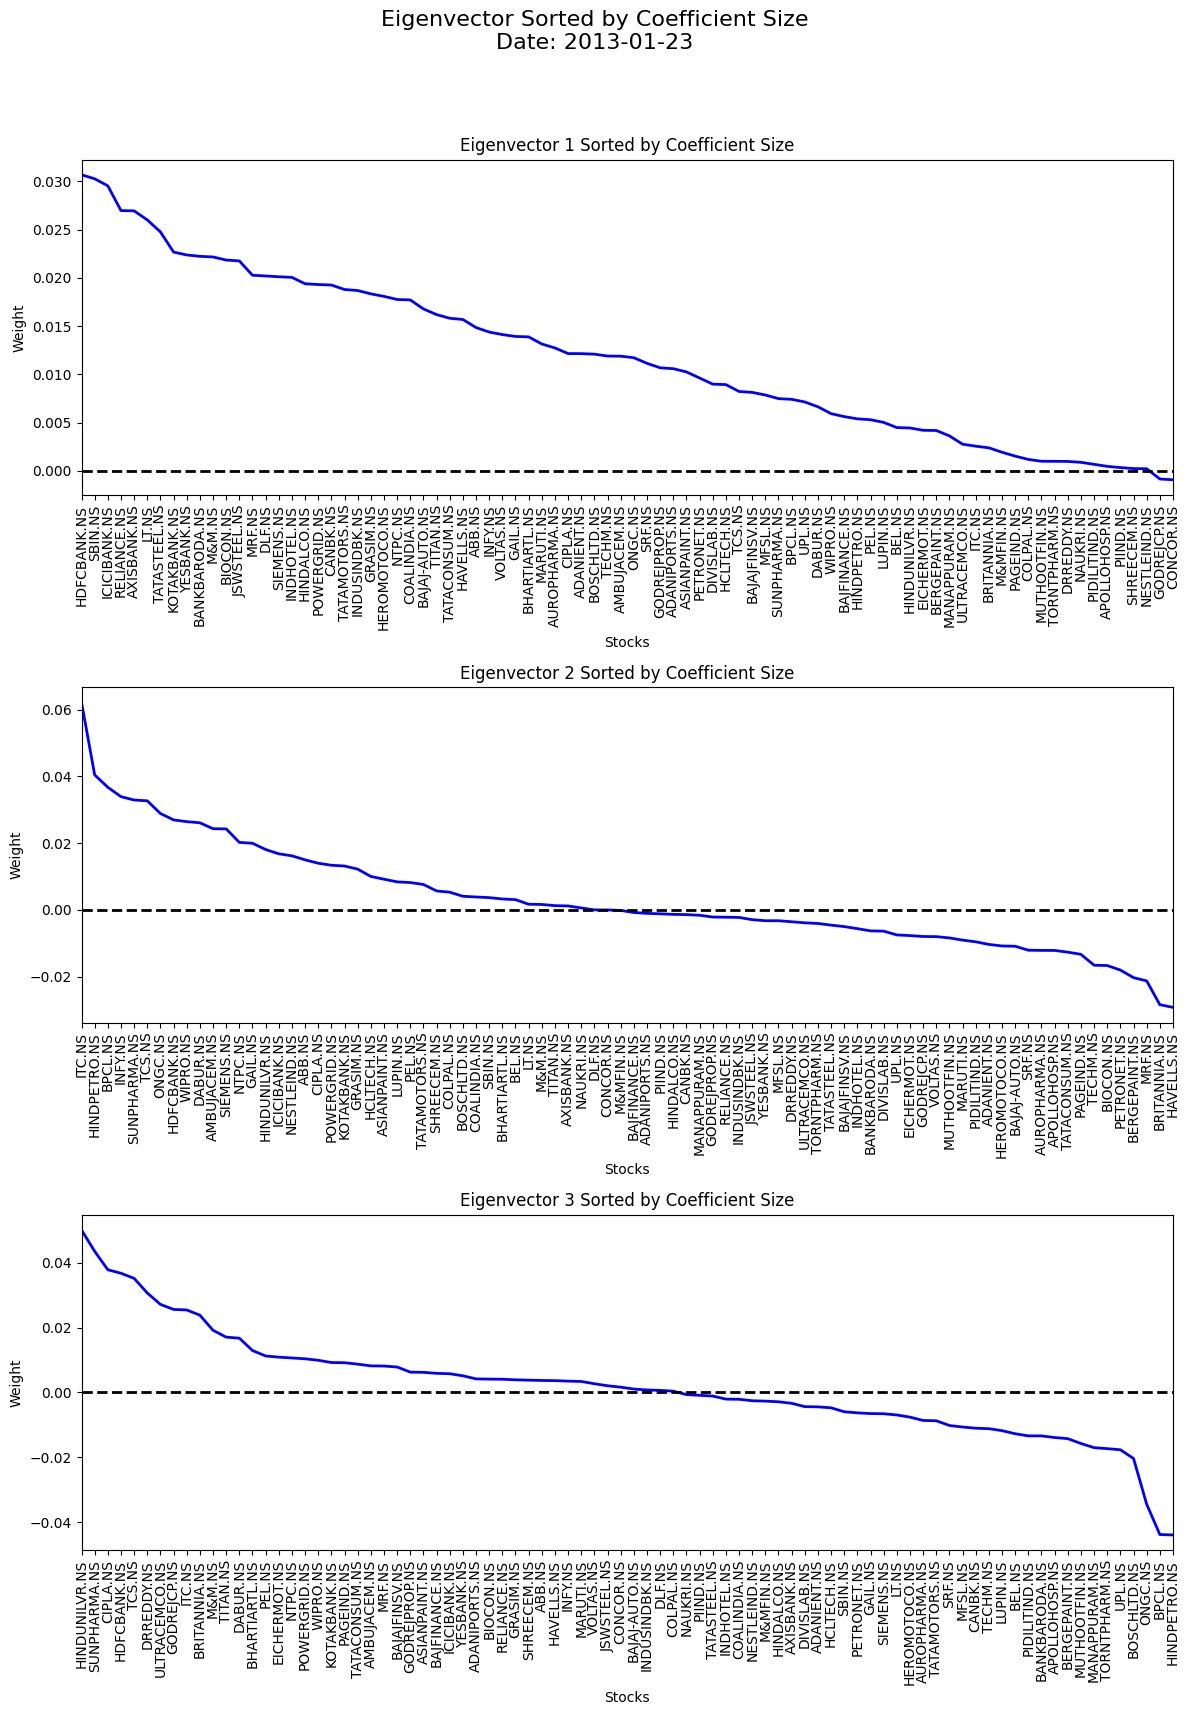

In [19]:
plot_eigenportfolio_weights(eigenportfolios_vw15, tickers, n_components=3 )

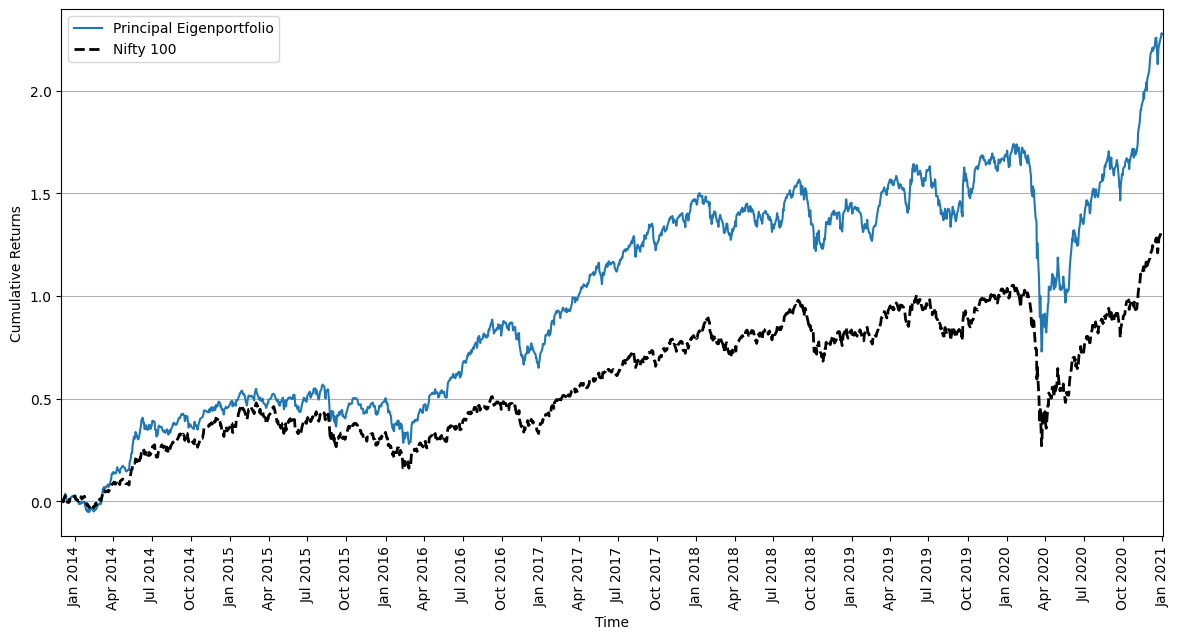

In [20]:
plot_eigenportfolio_returns(eigenportfolio_returns_dr15, nifty_returns, start_date= "2013-11-30", end_date="2020-12-31", n_portfolios=1)

Descriptive Statistics on the Mean-Reversion Time (τ):
Maximum: 11.90 days
75th Percentile: 4.29 days
Median: 2.84 days
25th Percentile: 1.88 days
Minimum: 0.19 days
Fast Days (< 8.4 days): 97.27%


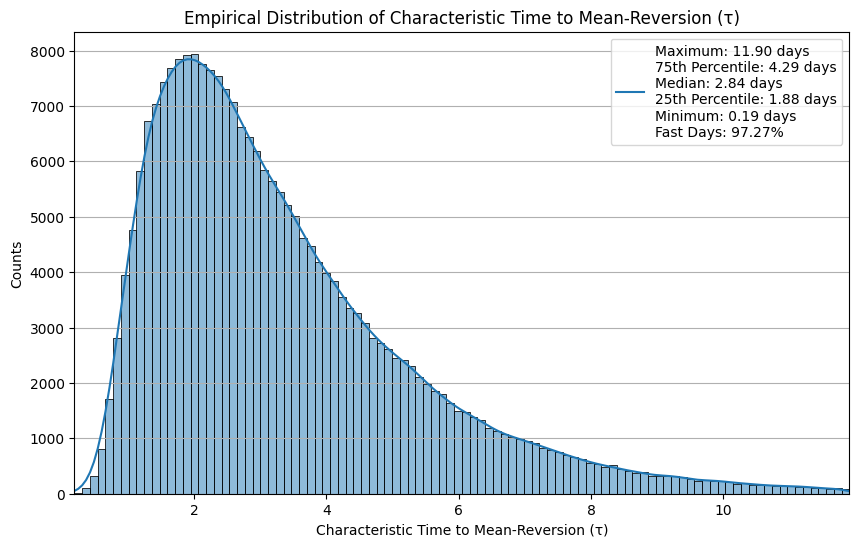

In [21]:
analyze_and_plot_taus(ou_parameters_dr55['taus'])

Computing ADF tests...


100%|██████████| 2834/2834 [04:45<00:00,  9.91it/s]


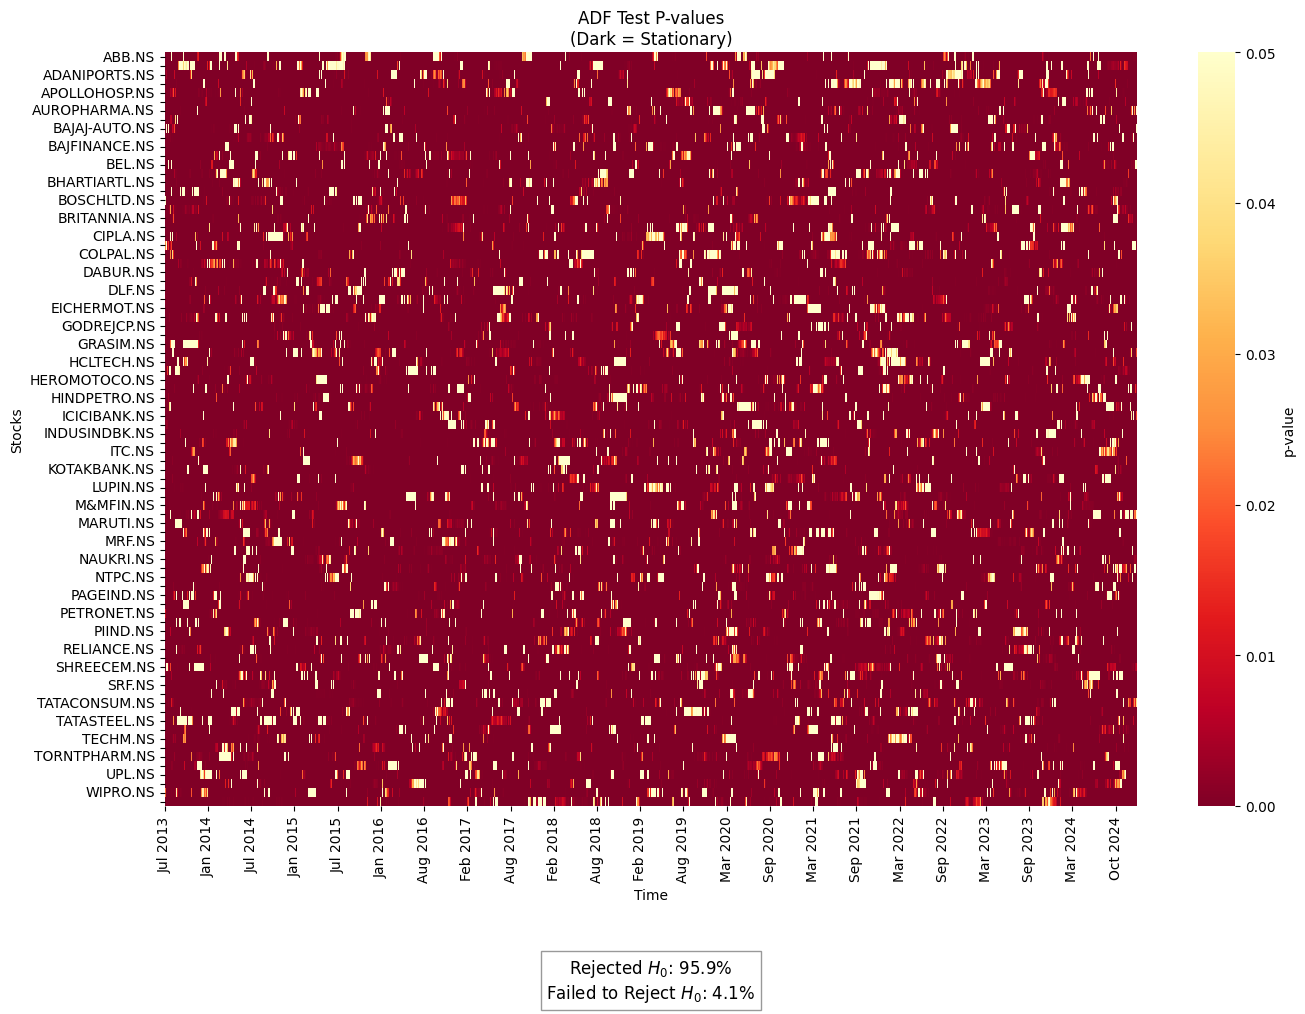

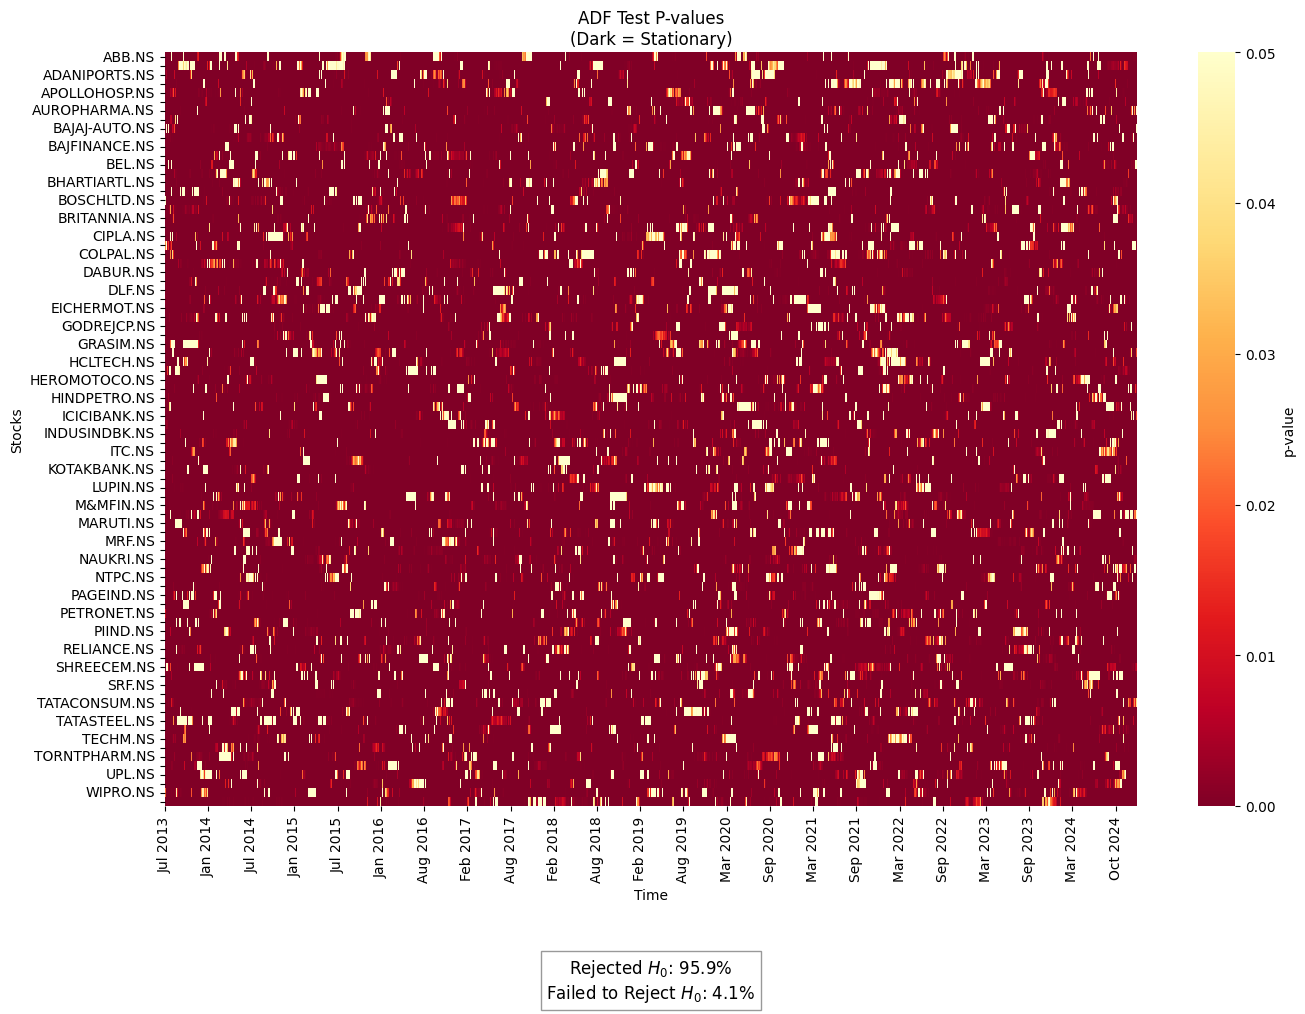

In [22]:
create_adf_heatmap(ou_parameters_dr1)

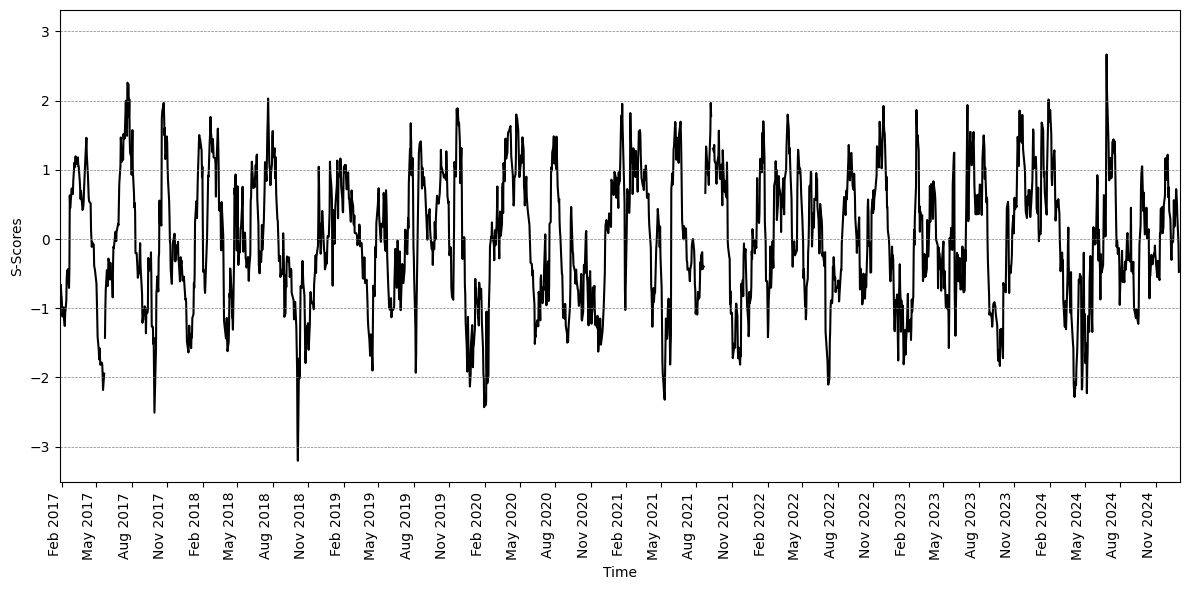

In [23]:
plot_s_scores(ou_parameters_dr1['s_scores']['RELIANCE.NS'], start_date= "2017-01-30", end_date="2024-12-31")

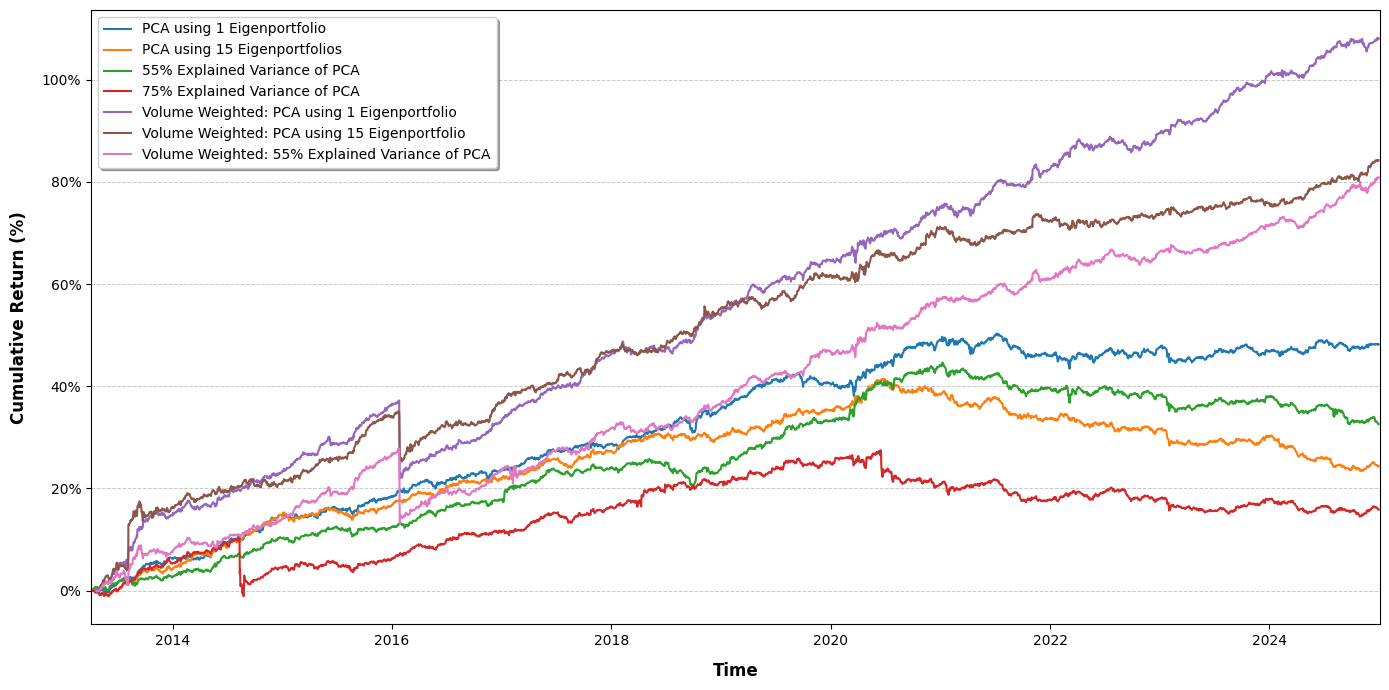

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

plt.figure(figsize=(14, 7))

dr1 = plot_cumulative_return(backtest_dr1, "PCA using 1 Eigenportfolio")
dr15 = plot_cumulative_return(backtest_dr15, "PCA using 15 Eigenportfolios")
dr55 = plot_cumulative_return(backtest_dr55, "55% Explained Variance of PCA")
dr75 = plot_cumulative_return(backtest_dr75, "75% Explained Variance of PCA" )
vw1 = plot_cumulative_return(backtest_vw1, "Volume Weighted: PCA using 1 Eigenportfolio")
vw15 = plot_cumulative_return(backtest_vw15, "Volume Weighted: PCA using 15 Eigenportfolio")
vw55 = plot_cumulative_return(backtest_vw55, "Volume Weighted: 55% Explained Variance of PCA")
#vw15_2x = plot_cumulative_return(backtest_vw1_2x, "2x Leverage")
#vw15_3x = plot_cumulative_return(backtest_vw1_3x, "3x Leverage")

start_date = dr15.index[0]

nifty_aligned = nifty_returns['^CNX100'][nifty_returns.index >= start_date]
cum_nifty = (1 + nifty_aligned).cumprod() - 1
#plt.plot(cum_nifty.index, cum_nifty.values, label='Nifty 100', linestyle='--', color='black')

plt.xlabel('Time', fontsize=12, fontweight='bold', labelpad=10)
plt.ylabel('Cumulative Return (%)', fontsize=12, fontweight='bold', labelpad=10)

plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))

plt.legend(
    fontsize=10,
    title_fontsize=12,
    loc='upper left',  
    frameon=True,     
    shadow=True       
)

plt.margins(x=0.001)
plt.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

plt.tight_layout()
plt.show()


In [25]:
calculate_sharpe_ratios(backtest_vw1_5x)

{'annual_sharpe_ratios': {2013: np.float64(2.55892875341947),
  2014: np.float64(0.42140242633859937),
  2015: np.float64(2.636736247640484),
  2016: np.float64(-0.13933705726668974),
  2017: np.float64(1.4126589619878862),
  2018: np.float64(1.4211384497376525),
  2019: np.float64(1.303214171728105),
  2020: np.float64(0.377078188488057),
  2021: np.float64(-0.15042913933894933),
  2022: np.float64(0.8311963280413787),
  2023: np.float64(0.9731395073835998),
  2024: np.float64(0.23931415411253248)},
 'since_inception_sharpe': np.float64(0.7182413485727299),
 'excess_returns': 2013-04-22   -0.006569
 2013-04-23    0.016114
 2013-04-25   -0.019890
 2013-04-26    0.006524
 2013-04-29    0.001881
                 ...   
 2024-12-24    0.004894
 2024-12-26    0.007371
 2024-12-27   -0.007091
 2024-12-30    0.005155
 2024-12-31    0.004254
 Length: 2875, dtype: float64}